In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, recall_score, confusion_matrix, precision_score, f1_score
import data_loader
import data_preprocessing

df = data_loader.load_bank_data('bank_data.csv')

X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = data_preprocessing.preprocessing(df)

print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)

results = {}

Dataset loaded successfully!
--- Data successfully preprocessed and split ---
Shape of X_train_scaled: (32950, 46)
Shape of X_test_scaled: (8238, 46)


In [13]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(7, 5))
    ax = sns.heatmap(
        cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
        linewidths=0.5, linecolor='gray',
        xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
        annot_kws={"size": 14, "weight": "bold"}
    )
    
    ax.set_title(f'Confusion Matrix – {model_name}', fontsize=16, pad=15)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=11)
    plt.tight_layout()

              precision    recall  f1-score   support

      No (0)       0.95      0.86      0.90      7310
     Yes (1)       0.37      0.65      0.47       928

    accuracy                           0.83      8238
   macro avg       0.66      0.75      0.69      8238
weighted avg       0.88      0.83      0.85      8238



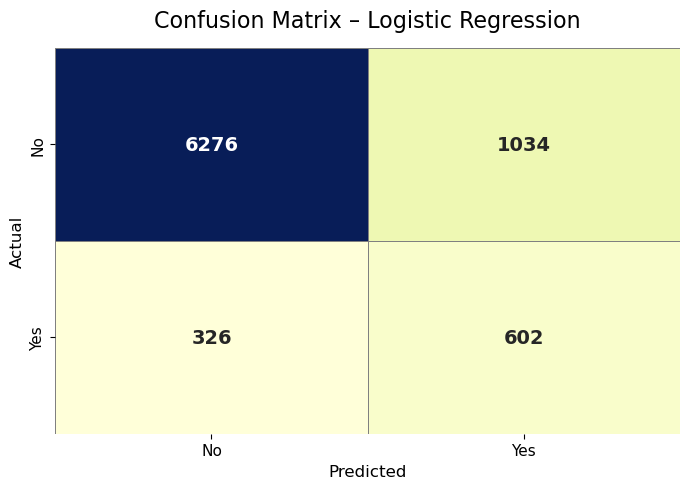

In [14]:
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

print(classification_report(y_test, y_pred_lr, target_names=['No (0)', 'Yes (1)']))
results["Logistic Regression"] = recall_score(y_test, y_pred_lr, pos_label=1)
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")

              precision    recall  f1-score   support

      No (0)       0.95      0.88      0.91      7310
     Yes (1)       0.39      0.64      0.49       928

    accuracy                           0.85      8238
   macro avg       0.67      0.76      0.70      8238
weighted avg       0.89      0.85      0.86      8238



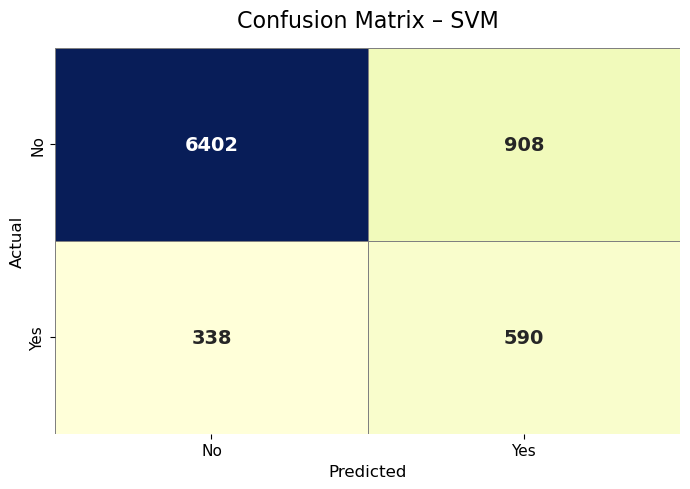

In [15]:
svm_model = SVC(class_weight='balanced', random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

print(classification_report(y_test, y_pred_svm, target_names=['No (0)', 'Yes (1)']))
results["SVM"] = recall_score(y_test, y_pred_svm, pos_label=1)
plot_confusion_matrix(y_test, y_pred_svm, "SVM")

              precision    recall  f1-score   support

      No (0)       0.91      0.97      0.94      7310
     Yes (1)       0.56      0.28      0.37       928

    accuracy                           0.89      8238
   macro avg       0.74      0.62      0.66      8238
weighted avg       0.87      0.89      0.88      8238



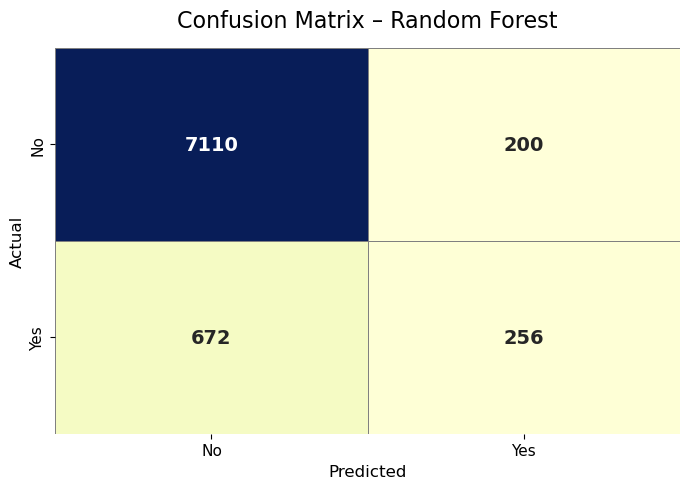

In [16]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print(classification_report(y_test, y_pred_rf, target_names=['No (0)', 'Yes (1)']))
results["Random Forest"] = recall_score(y_test, y_pred_rf, pos_label=1)
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

              precision    recall  f1-score   support

      No (0)       0.95      0.88      0.91      7310
     Yes (1)       0.38      0.61      0.47       928

    accuracy                           0.85      8238
   macro avg       0.67      0.74      0.69      8238
weighted avg       0.88      0.85      0.86      8238



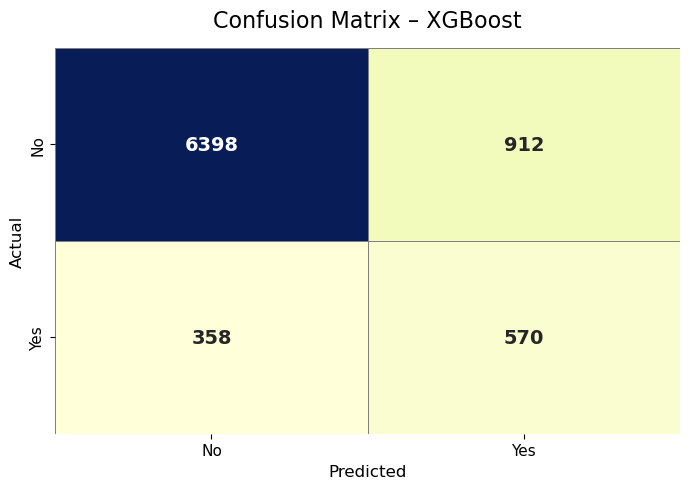

In [17]:
xgb_model = XGBClassifier(scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train), random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred_xgb, target_names=['No (0)', 'Yes (1)']))
results["XGBoost"] = recall_score(y_test, y_pred_xgb, pos_label=1)
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")

In [18]:
print("Ranked by Recall for the 'Yes' (Subscribed) Class:\n")

ranked_results = sorted(results.items(), key=lambda item: item[1], reverse=True)
for name, recall in ranked_results:
    print(f"{name:<20}: Recall = {recall:.2%}")

Ranked by Recall for the 'Yes' (Subscribed) Class:

Logistic Regression : Recall = 64.87%
SVM                 : Recall = 63.58%
XGBoost             : Recall = 61.42%
Random Forest       : Recall = 27.59%


In [21]:
predictions = {
    "Logistic Regression": y_pred_lr,
    "SVM": y_pred_svm,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

metric_data = []
for name, y_pred in predictions.items():
    recall = recall_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    metric_data.append([name, recall, precision, f1])

metrics_df = pd.DataFrame(metric_data, columns=['Model', 'Recall', 'Precision', 'F1-Score'])
metrics_df = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

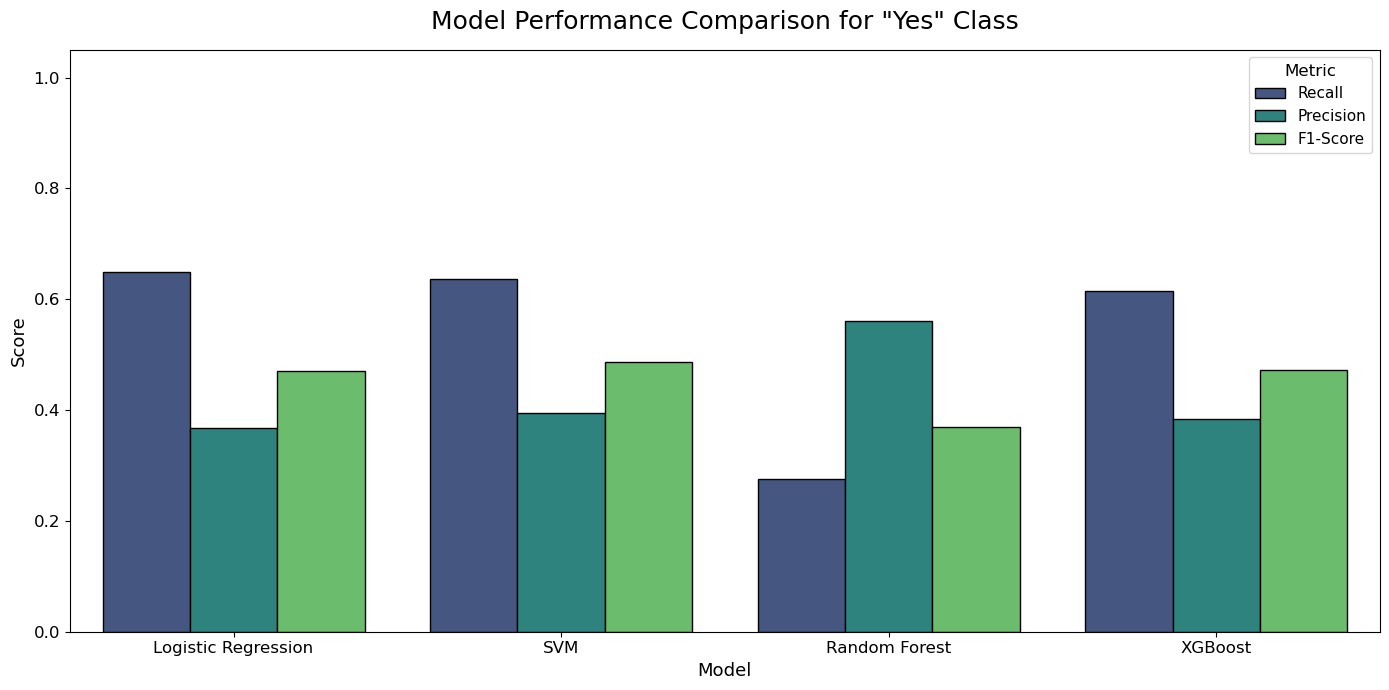

In [25]:
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    data=metrics_df,
    x='Model',
    y='Score',
    hue='Metric',
    palette='viridis',
    edgecolor='black'
)

plt.title('Model Performance Comparison for "Yes" Class', fontsize=18, pad=15)
plt.xlabel('Model', fontsize=13)
plt.ylabel('Score', fontsize=13)
plt.ylim(0, 1.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.grid(False)
ax.set_axisbelow(True)

plt.legend(
    title='Metric',
    title_fontsize=12,
    fontsize=11,
    frameon=True,
    loc='upper right'
)

plt.tight_layout()
plt.show()